In [63]:
import pyes
import pandas as pd
import elasticsearch
import os
import numpy as np
import time

#es_address='114.32.24.166:9200'
es_address='192.168.1.107:9200'
conn = pyes.es.ES(es_address) #create
bq = pyes.query.BoolQuery()

#找出想要的term出來
tq = pyes.query.TermQuery(field="fid", value="1448357445384692") 
tq1 = pyes.query.TermQuery(field="fid", value="139624776093433")
tq2 = pyes.query.TermQuery(field="fid", value="100489613340306")
#ESR = pyes.ESRange(field="created_at", from_value="Wed Jan 01 00:00:00 +0000 2014", to_value="Wed Dec 31 23:59:59 +0000 2014", 
#                   include_lower=True ,include_upper=True) #抓range
#rq = pyes.query.RangeQuery(qrange=ESR)
bq.add_should(tq) #must = AND, 將tq rq抓進來, 將成立的條件加進來
bq.add_should(tq1)
bq.add_should(tq2)

tagg = pyes.aggs.TermsAgg('fanpage_id', field= 'fid', sub_aggs=[]) 
tagg1 = pyes.aggs.DateHistogramAgg('date', field= 'created_time' , interval = 'day')
tagg.sub_aggs.append(tagg1) 
# 將tagg1加到tagg.sub_aggs裡面。
qsearch = pyes.query.Search(bq) 
qsearch.agg.add(tagg)

post = conn.search(query=qsearch , indices='facebook_nested' , doc_types='post') 
comment = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment') 
fanpage = conn.search(query=qsearch , indices='facebook_nested' , doc_types='fanpage')
#like = conn.search(query=qsearch , indices='facebook_nested' , doc_types='like') 

print len(post)
print len(comment)
print len(fanpage)
#print len(like)

6327
402099
3


# start date time & end date time & # of posts

In [64]:
# number of fans
for i in fanpage:
    if i['id'] == "1448357445384692":
        fans1 = i['likes_count']
    elif i['id'] == "139624776093433":
        fans2 = i['likes_count']
    else:
        fans3 = i['likes_count']
        
for i in post.aggs['fanpage_id']['buckets']:
    if i['key'] == '1448357445384692':
        print 'fanpage : ', i['key']
        print 'start date time : ', i['date']['buckets'][0]['key_as_string']
        print 'end date time : ', i['date']['buckets'][len(i['date']['buckets'])-1]['key_as_string']
        print '# of posts : ', i['doc_count']
        print '# of fans : ', fans1, '\n'
        
    elif i['key'] == '139624776093433':
        print 'fanpage : ', i['key'] 
        print 'start date time : ', i['date']['buckets'][0]['key_as_string']
        print 'end date time : ', i['date']['buckets'][len(i['date']['buckets'])-1]['key_as_string'] 
        print '# of posts : ', i['doc_count']
        print '# of fans : ', fans2, '\n'
    else: 
        print 'fanpage : ', i['key']
        print 'start date time : ', i['date']['buckets'][0]['key_as_string']
        print 'end date time : ', i['date']['buckets'][len(i['date']['buckets'])-1]['key_as_string'] 
        print '# of posts : ', i['doc_count']
        print '# of fans : ', fans3, '\n'
 

fanpage :  100489613340306
start date time :  2013-01-01T00:00:00.000Z
end date time :  2016-05-11T00:00:00.000Z
# of posts :  4238
# of fans :  1025150 

fanpage :  139624776093433
start date time :  2013-01-01T00:00:00.000Z
end date time :  2016-05-11T00:00:00.000Z
# of posts :  1120
# of fans :  580765 

fanpage :  1448357445384692
start date time :  2013-12-23T00:00:00.000Z
end date time :  2016-05-10T00:00:00.000Z
# of posts :  969
# of fans :  60673 



# comment from unique

In [68]:
fid1 = "1448357445384692" 
fid2 = "139624776093433"
fid3 = "100489613340306"

comment_unique = []

def comment(fid):
    conn = pyes.es.ES(es_address)
    tq = pyes.query.TermQuery(field="fid", value=fid)
    tagg = pyes.aggs.TermsAgg('fid', field= 'fid')
    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(tagg) 
    result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')
    
    for i in result:
        comment_unique.append(i['from']['id'])
        
    print 'fanpage :',fid,'comment from unique user :',len(np.unique(comment_unique))

comment(fid1)    
comment(fid2)
comment(fid3)

fanpage : 1448357445384692 comment from unique user : 12504
fanpage : 139624776093433 comment from unique user : 31894
fanpage : 100489613340306 comment from unique user : 139111


# Box plot (distribution #comments/each post among different facebook fans pages)

In [71]:
%matplotlib inline

import pyes
import json
import pandas as pd
import seaborn as sns

def boxPlotFBFansPageComp(fids,host,pngFilePath,outlierFilter):
    data=[]
    for fid in fids:
        conn = pyes.es.ES(host)
        tq = pyes.query.TermQuery(field="fid", value=fid)
        tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
        qsearch = pyes.query.Search(tq) 
        qsearch.agg.add(tagg) 
        result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')
        #print json.dumps(result.aggs,indent=2) 
        for fidpid_summary in result.aggs["pid"]["buckets"]:
            #print fidpid_summary["key"] + ',' + str(fidpid_summary["doc_count"])
            if fidpid_summary["doc_count"] < outlierFilter or outlierFilter < 0:
                data.append([fidpid_summary["doc_count"],fid,fidpid_summary["key"]])

    df=pd.DataFrame(data,columns={'count','fid','fidpid'})
    sns.set(style="ticks")
    sns_plot=sns.boxplot(x="fid", y="count", data=df, palette="PRGn")
    fig=sns_plot.get_figure()
    fig.savefig(pngFilePath)

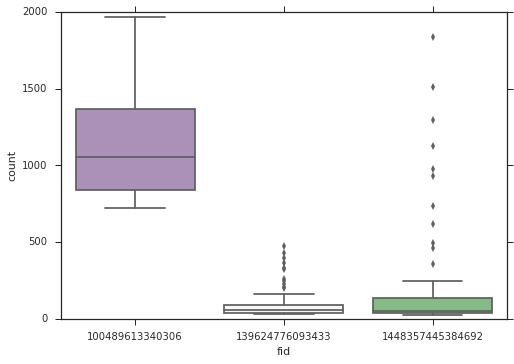

In [72]:
#assign the facebook fans page that you prefered
fids=['1448357445384692','139624776093433','100489613340306']

#elasticsearch repository provided by this course
#host = '114.32.24.166:9200'
host='192.168.1.107:9200'

#output box plot PNG figure
pngFilePath="output.png"

#outlier threshold you want to filter (if you give minus ONE, none of outlier is filtered.)
outlierFilter=2000

#obtain the result and save as "pngFilePath" given from you
boxPlotFBFansPageComp(fids,host,pngFilePath,outlierFilter)

# Box plot (#post per month for specified page)

In [201]:
import pyes
import json
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt


def boxPlotNumofPostPerMonth(fid,host,lowerbound,upperbound,pngFilePath):
    conn = pyes.es.ES(host)
    tq = pyes.query.TermQuery(field="fid", value=fid)
    #tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
    DHAgg = pyes.aggs.DateHistogramAgg('month' ,field='created_time', interval='month',sub_aggs=[])
    tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
    DHAgg.sub_aggs.append(tagg) 
    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(DHAgg) 
    result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')

    data=[]
    for r in result.aggs["month"]["buckets"]:
        for pid in r["pid"]["buckets"]:
            monthyear=datetime.datetime.strptime(r["key_as_string"], "%Y-%m-%dT%H:%M:%S.%fZ").strftime('%Y/%m')
            data.append([pid["doc_count"],monthyear,pid["key"],r["key"]])

    df=pd.DataFrame(data,columns={'date','count','fid','pid'})
    sns.set(style="ticks")
    sns_plot=sns.boxplot(x="date", y="count", data=df, palette="PRGn")
    fig=sns_plot.get_figure()
    plt.ylim(lower_bound, upper_bound)
    fig.savefig(pngFilePath)

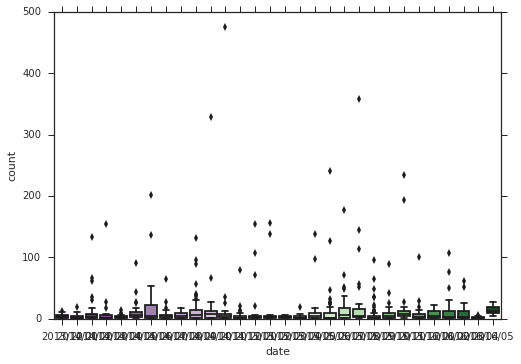

In [202]:
lower_bound = 0
upper_bound = 500
fid="1448357445384692"
pngFilePath="output3.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

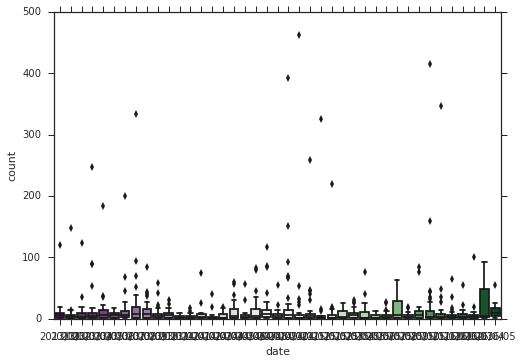

In [203]:
lower_bound = 0
upper_bound = 500
fid="139624776093433"
pngFilePath="output3.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

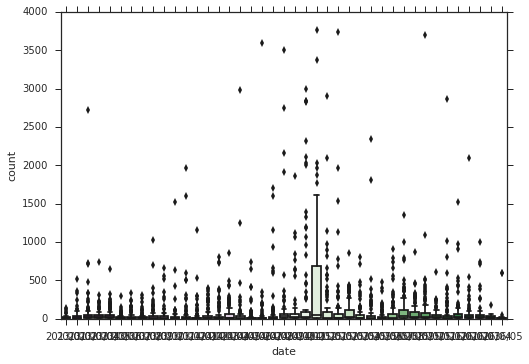

In [204]:
lower_bound = 0
upper_bound = 4000
fid="100489613340306"
pngFilePath="output3.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

# # of post & # / Ratio of post with sharing

In [286]:
pshare1 = 0
pshare2 = 0
pshare3 = 0

for i in post.aggs['fanpage_id']['buckets']:
    if i['key'] == '1448357445384692':
        print 'fanpage : ', i['key']
        print '# of posts : ', i['doc_count']
        p1 = i['doc_count']
    elif i['key'] == '139624776093433':
        print 'fanpage : ', i['key'] 
        print '# of posts : ', i['doc_count']
        p2 = i['doc_count']
    else: 
        print 'fanpage : ', i['key']
        print '# of posts : ', i['doc_count']
        p3 = i['doc_count']

for a in post:
    if a['fid'] == '1448357445384692':
        if a['shares']['count'] > 0:
            pshare1+=1
    elif a['fid'] == '139624776093433':
        if a['shares']['count'] > 0:
            pshare2+=1
    else:
        if a['shares']['count'] > 0:
            pshare3+=1

print  'fanpage : 1448357445384692','# of post with sharing : ',pshare1,'ratio of post with sharing : ',p1/pshare1
print  'fanpage : 139624776093433','# of post with sharing : ',pshare2,'ratio of post with sharing : ',p2/pshare2
print  'fanpage : 100489613340306','# of post with sharing : ',pshare3,'ratio of post with sharing : ',p3/pshare3


AttributeError: 'function' object has no attribute 'aggs'

# Get User-Post frequence matrix
input {es address, row name, column name, fans page ID}

In [221]:
import pyes
import json

def getUserPostFreqMatrix(es_address,row,column,fid):
    rc=200
    cc=200
    
    rowIndexList,colIndexList,matrix = [],[],[]
    conn=pyes.es.ES(es_address)
    tq = pyes.query.TermQuery(field="fid", value=fid)

    tagg = pyes.aggs.TermsAgg(row, field= row, sub_aggs=[]) 
    tagg1 = pyes.aggs.TermsAgg(column, field= column)  
    tagg.sub_aggs.append(tagg1) 

    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(tagg)

    rs = conn.search(query=qsearch, indices='facebook_nested' ,type="comment" )
    
    rowcount=0
    colcount=0
    for user in rs.aggs[row]['buckets']:
        if user['key']!="" and user['key'] not in rowIndexList and rowcount<rc:
            rowIndexList.append(user['key'])
            rowcount=rowcount+1

        for post in user[column]['buckets']:
            if post['key'] not in colIndexList and colcount<cc:
                colIndexList.append(post['key'])
                colcount=colcount+1

    for i in range(0,len(rowIndexList)):
        matrix.append([0.0]*len(colIndexList))

    for user in rs.aggs[row]['buckets']:
        if user["key"] in rowIndexList:
            for post in user[column]['buckets']:
                if post['key'] in colIndexList:
                    matrix[rowIndexList.index(user['key'])][colIndexList.index(post['key'])]= float(post['doc_count'])
    
    
    return {"data":matrix,"col":colIndexList,"row":rowIndexList}

In [226]:
#es_address="114.32.24.166:9200"
es_address="192.168.1.107:9200"
row="from.id"
column="fid_pid"
fid="1448357445384692"
result = getUserPostFreqMatrix(es_address,row,column,fid)

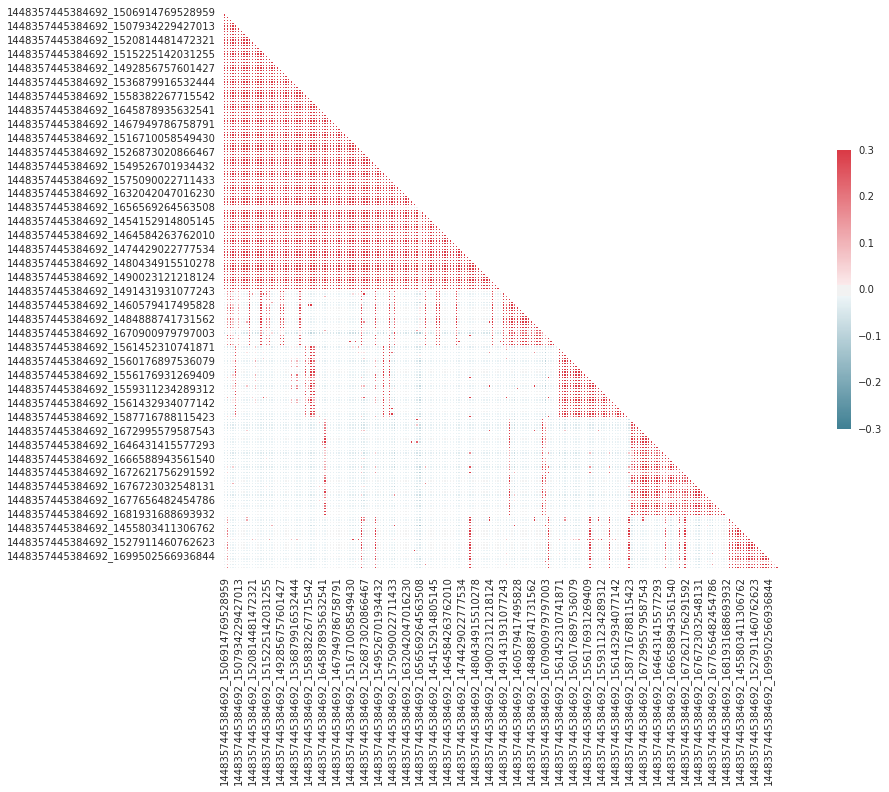

In [227]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=result["data"],
                 columns=result["col"])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [230]:
#es_address="114.32.24.166:9200"
es_address="192.168.1.107:9200"
row="from.id"
column="fid_pid"
fid="139624776093433"
result = getUserPostFreqMatrix(es_address,row,column,fid)

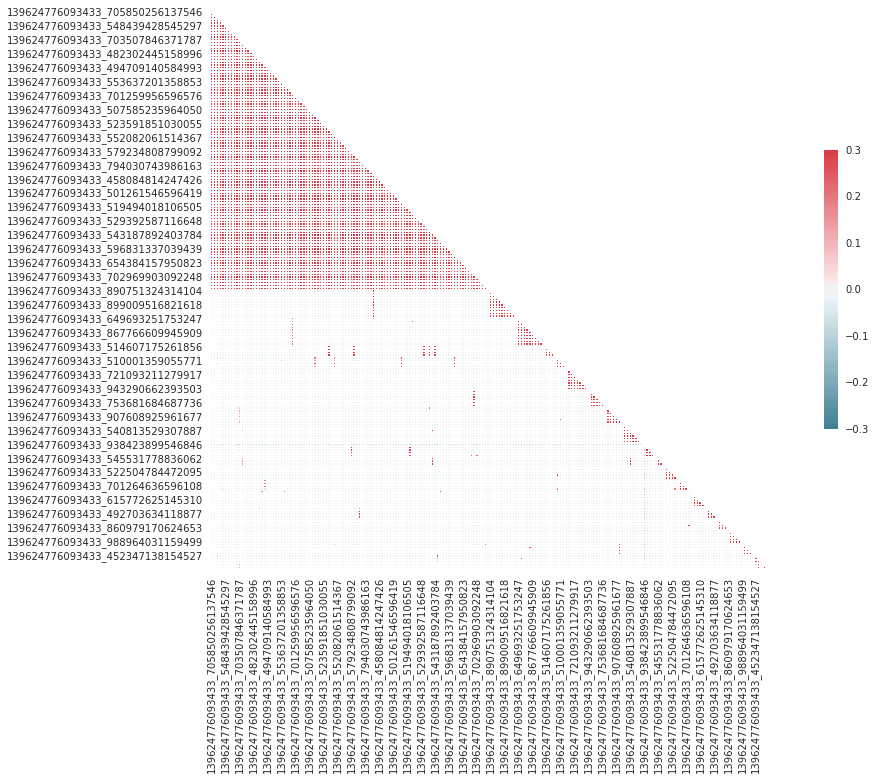

In [231]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=result["data"],
                 columns=result["col"])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [253]:
#es_address="114.32.24.166:9200"
es_address="192.168.1.107:9200"
row="from.id"
column="fid_pid"
fid="100489613340306"
result = getUserPostFreqMatrix(es_address,row,column,fid)

TypeError: 'NoneType' object is not callable

In [ ]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=result["data"],
                 columns=result["col"])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)